In [40]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [42]:
df = pd.read_hdf('data/data_X.h5') # load data processed with ML_processor.py

sig_df = df[df['signal']==1]
bkg_df = df[df['signal']==0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = ['met','ht','njets','bjets','min_dphi_met_j1','min_dphi_met_j2','min_dphi_met_j3','min_dphi_met_j4','signal']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 275 events


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


defined bkg and sig training
defined canvas


ValueError: x must have 2 or fewer dimensions

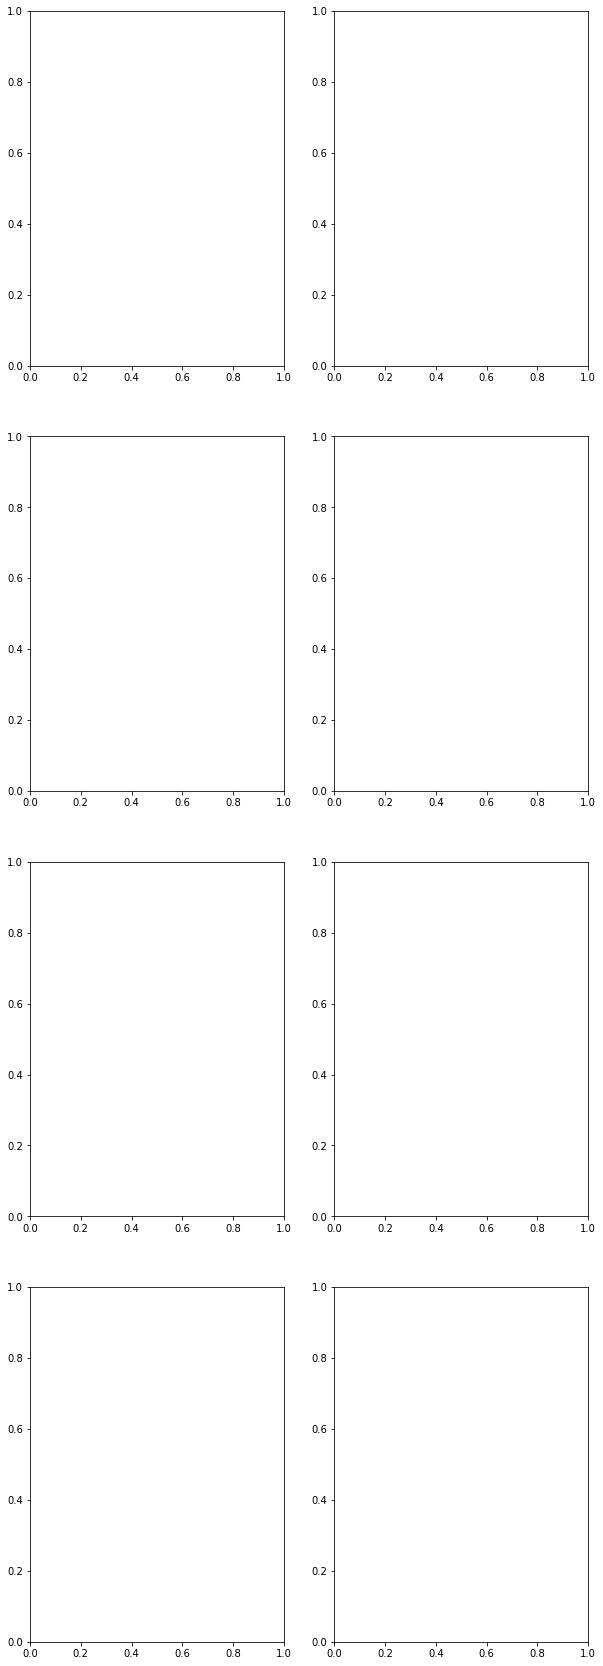

In [43]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]
print("defined bkg and sig training")

fig, axs = plt.subplots(4,2, figsize=(10,30))
print ("defined canvas")

#hist, bins, ax = axs[0,0].hist( [ X_bkg[['met']].values, X_sig[['met']].values ], range(0,500,25), histtype='step', linewidth=2, label=['ttbar', 'WH']) 
hist, bins, ax = axs[0,1].hist( [ X_bkg[['ht']].values, X_sig[['ht']].values ], range(0,1500,50), histtype='step', linewidth=2) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['njets']].values, X_sig[['njets']].values ], range(0,15,1), histtype='step', linewidth=2) 
hist, bins, ax = axs[1,1].hist( [ X_bkg[['bjets']].values, X_sig[['bjets']].values ], range(0,15,1), histtype='step', linewidth=2) 
hist, bins, ax = axs[2,0].hist( [ X_bkg[['min_dphi_met_j1']].values, X_sig[['min_dphi_met_j1']].values ], range(0,3.5,0.5), histtype='step', linewidth=2, label=['tt', 'WH']) 
hist, bins, ax = axs[2,1].hist( [ X_bkg[['min_dphi_met_j2']].values, X_sig[['min_dphi_met_j2']].values ], range(0,3.5,0.5), histtype='step', linewidth=2, label=['tt', 'WH']) 
hist, bins, ax = axs[3,0].hist( [ X_bkg[['min_dphi_met_j3']].values, X_sig[['min_dphi_met_j3']].values ], range(0,3.5,0.5), histtype='step', linewidth=2, label=['tt', 'WH']) 
hist, bins, ax = axs[3,1].hist( [ X_bkg[['min_dphi_met_j4']].values, X_sig[['min_dphi_met_j4']].values ], range(0,3.5,0.5), histtype='step', linewidth=2, label=['tt', 'WH']) 

axs[0,0].set_xlabel(r'$E_{T}^{miss}$')
axs[0,1].set_xlabel(r'$H_{T}$')
axs[1,0].set_xlabel(r'$N_{jet}$')
axs[1,1].set_xlabel(r'$N_{b jet}$')
axs[2,0].set_xlabel(r'$dphi(met,j0)~{min}$')
axs[2,1].set_xlabel(r'$dphi(met,j1)~{min}$')
axs[3,0].set_xlabel(r'$dphi(met,j2)~{min}$')
axs[3,1].set_xlabel(r'$dphi(met,j3)~{min}$')

axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()
axs[3,0].legend()

In [51]:
# Normalize Data - mean to 0, and std to 1 
X_mean, X_std = X_train.mean(), X_train.std()

X_train -= X_mean
X_train /= X_std

X_test -= X_mean
X_test /= X_std

KeyError: "['mll'] not in index"

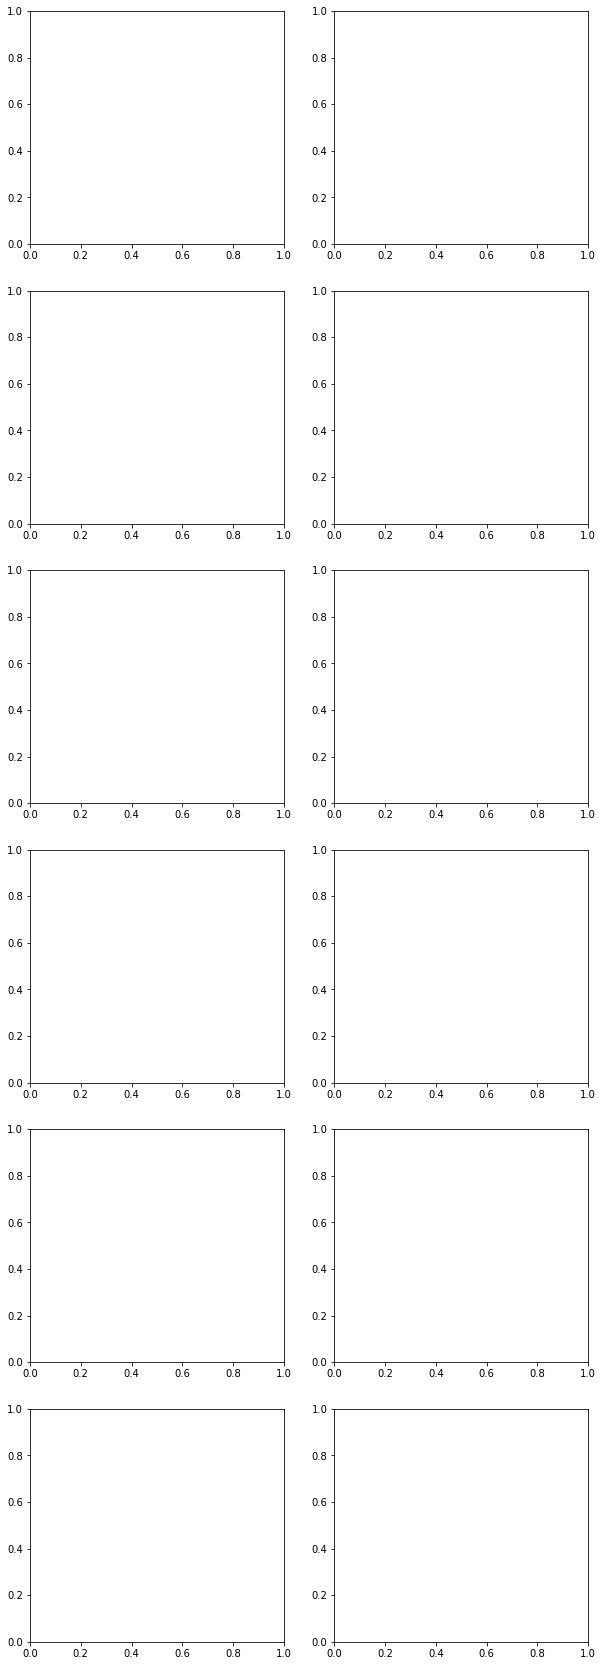

In [52]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(6,2, figsize=(10,30))

binning = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]

hist, bins, ax = axs[0,0].hist( [ X_bkg[['mll']].values, X_sig[['mll']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW'])
#hist, bins, ax = axs[0,1].hist( [ X_bkg[['njet']].values, X_sig[['njet']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['st']].values, X_sig[['st']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW'])
hist, bins, ax = axs[1,1].hist( [ X_bkg[['ht']].values, X_sig[['ht']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[2,0].hist( [ X_bkg[['met']].values, X_sig[['met']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[2,1].hist( [ X_bkg[['mjj_max']].values, X_sig[['mjj_max']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[3,0].hist( [ X_bkg[['mlb_min']].values, X_sig[['mlb_min']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[3,1].hist( [ X_bkg[['mlb_max']].values, X_sig[['mlb_max']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[4,0].hist( [ X_bkg[['l0_pt']].values, X_sig[['l0_pt']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[4,1].hist( [ X_bkg[['l1_pt']].values, X_sig[['l1_pt']].values ], binning, histtype='step', linewidth=2) 
hist, bins, ax = axs[5,0].hist( [ X_bkg[['deltaR_lj_min']].values, X_sig[['deltaR_lj_min']].values ], binning, histtype='step', linewidth=2, label=['tt', 'ttW']) 
hist, bins, ax = axs[5,1].hist( [ X_bkg[['j0_pt']].values, X_sig[['j0_pt']].values ], binning, histtype='step', linewidth=2) 

axs[0,0].set_xlabel(r'$M_{\ell\ell}$')
axs[0,1].set_xlabel(r'$N_{jet}$')
axs[1,0].set_xlabel(r'$S_{T}$')
axs[1,1].set_xlabel(r'$H_{T}$')
axs[2,0].set_xlabel(r'$E_{T}^{miss}$')
axs[2,1].set_xlabel(r'$M_{jj}~(max)$')
axs[3,0].set_xlabel(r'$M_{lb}~{min}$')
axs[3,1].set_xlabel(r'$M_{lb}~(max)$')
axs[4,0].set_xlabel(r'$p_{T}~(leading)$')
axs[4,1].set_xlabel(r'$p_{T}~(trailing)$')

axs[0,0].legend()
axs[1,0].legend()
axs[2,0].legend()
axs[3,0].legend()
axs[4,0].legend()

In [53]:
epochs = 50
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Dense(units=20, activation='relu', input_dim=X_train.shape[1], ))
model.add( tf.keras.layers.Dense(units=40, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                200       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


In [54]:
from ML.lrcurve import KerasLearningCurve

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0, callbacks=[KerasLearningCurve()])


In [55]:
#model.save( 'data/training.h5', include_optimizer=False )
model.save_weights( 'data/training_weights.h5' )
model.save( 'data/training.h5' )

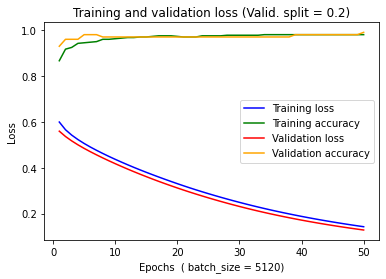

In [56]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)

plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

ValueError: x must have 2 or fewer dimensions

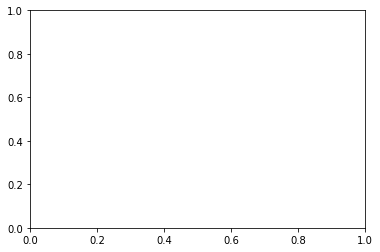

In [45]:
loaded_model = tf.keras.models.load_model('data/training.h5')

# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( loaded_model.predict( X_test.values  ) , index = X_test.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values, y_test_pred[y_test==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

ValueError: x must have 2 or fewer dimensions

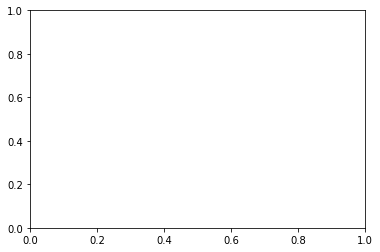

In [57]:
# use the model to predict whether an event is signal or background. this is with the training set
y_train_pred = pd.DataFrame( loaded_model.predict( X_train.values  ) , index = X_train.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_train_pred[y_train==0].values, y_train_pred[y_train==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

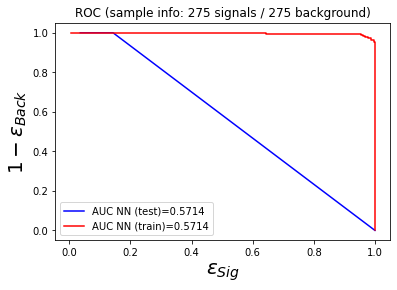

In [58]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, y_train_pred )
auc_val_train = auc(fpr_test, tpr_test)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))


plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


In [ ]:
means = pd.DataFrame(X_mean)
with open('data/means.json', 'w') as f:
    f.write(means.to_json())

# load the data frame and convert it to a series with squeeze
means = pd.read_json('data/means.json').squeeze()

stds = pd.DataFrame(X_std)
with open('data/stds.json', 'w') as f:
    f.write(stds.to_json())

# load the data frame and convert it to a series with squeeze
stds = pd.read_json('data/stds.json').squeeze()

In [46]:
X_train.values

array([[8.00711792e+02, 1.07509375e+03, 6.00000000e+00, ...,
        2.21165228e+00, 2.00061035e+00, 1.00000000e+00],
       [4.01640533e+02, 1.24056250e+03, 5.00000000e+00, ...,
        1.69921950e-01, 1.69921950e-01, 0.00000000e+00],
       [4.28902802e+02, 1.38187500e+03, 7.00000000e+00, ...,
        1.23229906e-01, 1.23229906e-01, 0.00000000e+00],
       ...,
       [5.74642273e+02, 1.05353125e+03, 7.00000000e+00, ...,
        2.13836640e-01, 2.13836640e-01, 1.00000000e+00],
       [5.09535034e+02, 9.05187500e+02, 3.00000000e+00, ...,
        3.27148408e-01, 3.27148408e-01, 0.00000000e+00],
       [7.10593445e+02, 1.37346875e+03, 4.00000000e+00, ...,
        1.07617188e+00, 8.33007812e-01, 1.00000000e+00]])

In [47]:
y_train_pred = pd.DataFrame( model.predict( X_train.values  ) , index = X_train.index)

In [48]:
model_l = tf.keras.models.load_model('data/training.h5a')
model.predict( X_train.values  )

OSError: Unable to open file (unable to open file: name = 'data/training.h5a', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [49]:
import pickle
#with  as f:
pickle.dump(X_train, open('test.pkl', "wb"))

In [50]:
pickle.load(open('test.pkl', 'rb'))

,met,ht,njets,bjets,min_dphi_met_j1,min_dphi_met_j2,min_dphi_met_j3,min_dphi_met_j4,signal
2196,800.711792,1075.093750,6.0,2.0,2.881012,2.211652,2.211652,2.000610,1.0
251,401.640533,1240.562500,5.0,2.0,2.997917,0.169922,0.169922,0.169922,0.0
136,428.902802,1381.875000,7.0,2.0,2.915021,0.123230,0.123230,0.123230,0.0
1809,575.370300,1186.687500,4.0,2.0,2.025208,2.025208,2.025208,1.584747,1.0
167,623.639465,1111.531250,3.0,1.0,3.138663,0.112305,0.112305,0.112305,0.0
68,402.541046,919.000000,2.0,1.0,2.991089,0.273560,0.273560,0.273560,0.0
367,405.124420,785.046875,6.0,1.0,2.417728,2.161847,1.851056,1.728027,1.0
1010,463.265259,1305.906250,3.0,1.0,2.418762,1.355896,0.045227,0.045227,1.0
507,610.994751,1235.250000,3.0,1.0,2.686994,1.329712,0.913818,0.913818,1.0
2514,474.160522,913.906250,4.0,1.0,2.356689,1.786847,1.786847,1.786847,1.0
